In [1]:
pip install --index-url https://test.pypi.org/simple/ --no-deps generator-aj429467==0.2.0

Looking in indexes: https://test.pypi.org/simple/


In [2]:
pip install clearml

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 42.0 MB/s eta 0:00:00
  Attempting uninstall: pyjwt
    Found existing installation: PyJWT 2.10.1
    Uninstalling PyJWT-2.10.1:
      Successfully uninstalled PyJWT-2.10.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
generator-aj429467 0.2.0 requires clearml~=1.10.1, but you have clearml 1.18.0 which is incompatible.
generator-aj429467 0.2.0 requires numpy~=2.1.3, but you have numpy 2.0.2 which is incompatible.
generator-aj429467 0.2.0 requires pandas~=2.2.3, but you have pandas 2.2.2 which is incompatible.
generator-aj429467 0.2.0 requires pytest~=8.1.0, but you have pytest 8.3.5 which is incompatible.


In [2]:
# @title Download data
from src.utils.utils import unpack_and_read

unpack_and_read()

Downloading...
From (original): https://drive.google.com/uc?id=1xsDZF8PZUNNzYAVrfuNxGoLMhoEFgAuN
From (redirected): https://drive.google.com/uc?id=1xsDZF8PZUNNzYAVrfuNxGoLMhoEFgAuN&confirm=t&uuid=18795797-f4d8-4719-ae28-a7a6116021bf
To: /content/data.csv.gz
100%|██████████| 655M/655M [00:11<00:00, 57.7MB/s]


,Exp_ID,Image_Metadata_Site,track_id,Image_Metadata_T,Nuclear_size,ERKKTR_ratio,FoxO3A_ratio,objNuclei_Location_Center_X,objNuclei_Location_Center_Y
0,1,1,1,0,303.0000,0.704407,1.33383,932.211,875.248
1,1,1,1,1,333.0000,0.848242,1.33791,932.150,874.174
2,1,1,1,2,314.0000,1.059170,1.37627,932.376,873.787
3,1,1,1,3,322.0000,1.188000,1.35754,932.168,873.453
4,1,1,1,4,313.9990,1.205540,1.36695,931.146,872.885
...,...,...,...,...,...,...,...,...,...
35541643,6,24,1372,253,81.9999,1.287450,1.34448,698.317,223.537
35541644,6,24,1372,254,83.0000,1.265500,1.31116,697.506,224.217
35541645,6,24,1372,255,83.0000,1.263590,1.30931,697.410,223.988
35541646,6,24,1372,256,80.0002,1.249440,1.25123,696.400,224.488


Using device: cpu


Creating frames: 100%|██████████| 258/258 [01:15<00:00,  3.44it/s]


torch.Size([1, 258, 3, 600, 800])


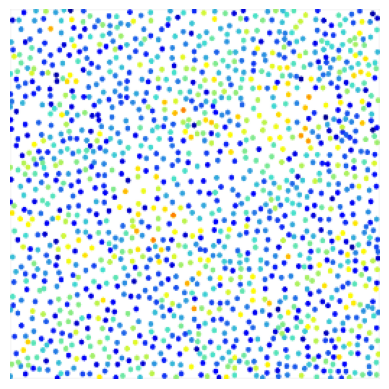

In [5]:
# @title Load data to tensor and vizualize tensor
import torch
from src.data_processing.data_processing import (
    load_experiment_data_to_tensor,
    TensorDataset,
    get_dataloader
)
import src.visualizer.visualizer as visualizer

print(f"Using device: {torch.device('cuda') if torch.cuda.is_available() else torch.device('mps') if torch.backends.mps.is_available() else torch.device('cpu')}")

load_experiment_data_to_tensor(
    experiments=(1,),
    maintain_experiment_visualization=True,
    data_path="data.csv.gz",
    tensor_path="data/tensors_to_load",
    custom_gif_path="./",
    num_fields_of_view = 1
)

sample_tensor = torch.load("data/tensors_to_load/experiments_tensor_exp_1_fov_1.pt")
visualizer.visualize_tensor_image(sample_tensor[0][0])


In [1]:
# @title RuleBasedGenerator pipeline
from src.rule_based_generator.rule_based_generator import RuleBasedGenerator
import src.utils.utils as utils
import src.generator.generator as generator
import src.visualizer.visualizer as visualizer

df = utils.unpack_and_read('data.csv.gz')
df_first_frame = df[(df['Image_Metadata_Site'] == 1) & (df['Exp_ID'] == 1) & (df['Image_Metadata_T'] == 0)][
['track_id', 'objNuclei_Location_Center_X', 'objNuclei_Location_Center_Y', 'ERKKTR_ratio', 'Image_Metadata_T']]
generator = RuleBasedGenerator(df_first_frame=df_first_frame)
video_data = generator.generate_video()
visualizer.visualize_simulation(video_data, path = "simulation.gif", temp_frames_dir="temp_frames")

Creating frames: 100%|██████████| 258/258 [01:16<00:00,  3.36it/s]


In [ ]:
# @title ModelBased generation pipeline

from src.model.model import ModelArgs
from src.model.model import SpatioTemporalTransformer
import src.transformations.transformations as transformations

args = ModelArgs()
model = SpatioTemporalTransformer(args)
frames = transformations.transform_gif_to_tensor("experiment_1_fov_1.gif")
print(frames.shape)
frames = transformations.transform_image_to_trainable_form(frames)
print(frames.shape)
output = model(frames)
print(output.shape)

torch.Size([1, 258, 3, 600, 800])
torch.Size([1, 258, 3, 256, 256])
torch.Size([1, 258, 3, 256, 256])


In [6]:
# @title Trainer pipeline

from src.trainer.trainer import Trainer
import src.model.model as model
import src.data_processing.data_processing as data_processing
import src.transformations.transformations as transformations
import src.generator.generator as generator
import src.visualizer.visualizer as visualizer
import torch

if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
elif torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
else:
    DEVICE = torch.device("cpu")

trainer = Trainer(
        n_epochs=1,
        lr=2e-3,
        batch_size=1,
        load_to_ram=False,
        batch_norm_momentum=0.01,
        extra_augmentation=lambda image: transformations.transformations_for_training(image, crop_size=16),
        data_folder = "./data/tensors_to_load"
)
args = model.ModelArgs()
model = model.SpatioTemporalTransformer(args).to(DEVICE)
    # model = load_model("../../data/model/saved_model64_200_alternative.pth", 'SpatioTemporalTransformer', DEVICE)
trainer.train(model)
    # save_model(model, model.args, "../../data/model/saved_model16.pth")

train_loader, test_loader = data_processing.get_dataloader(
    data_folder = "./data/tensors_to_load",
    batch_size=1,
    transform=lambda image: transformations.transformations_for_evaluation(image, crop_size=16), # in order to ram usage only 16
)
model.eval().to(DEVICE)
batch = next(iter(test_loader)).to(DEVICE)
generated_video = generator.generate_video_from_tensor(model, batch[:, :100], video_length=258)
generated_video = transformations.unnormalize_image(generated_video)
visualizer.visualize_tensor_images_as_gif(generated_video[0], path="animation.gif")

Generating rest of the video: 100%|██████████| 158/158 [00:43<00:00,  3.59it/s]
